In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab_Notebooks/DeepSynergy"
import os
os.chdir(path)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import pickle 
import gzip

In [3]:
#contains the data in 
#both feature ordering ways (drug A - drug B - cell line and drug B - drug A - cell line)
#in the first half of the data the features are ordered (drug A - drug B - cell line)
#in the second half of the data the features are ordered (drug B - drug A - cell line)
file = gzip.open('./dataset/X.p.gz', 'rb')
X = pickle.load(file)
file.close()

For 15 overlapping drugs

In [4]:
drugs = pd.read_csv('dataset/ONeil38_Drug732.csv')
drugs_name = drugs['ONeil_name'].str.upper()

# find the index where combinations only involves the 15 overlapping drugs
labels = pd.read_csv('dataset/labels.csv')  # y's for one ordering way
selected = labels[(labels['drug_a_name'].isin(drugs_name)) & (labels['drug_b_name'].isin(drugs_name))]

# regenerate folds 
import random
random.seed(123)
selected.fold = 5

each_num = int(len(selected)/5)
folds = np.array(each_num*[0]+each_num*[1]+each_num*[2]+each_num*[3]+(len(selected)-4*each_num)*[4])
random.shuffle(folds)

selected.loc[:,'fold'] = folds
selected.to_csv('dataset/labels_15.csv')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [5]:
selected.shape

(3003, 6)

## The following part is for embedding


Cell line

In [6]:
cell_line = X[:,-3984:]

每个gene的count除以该细胞的总count,乘以缩放因子10000再进行log1p处理

In [7]:
cell_line_norm = np.log10(np.divide(cell_line, cell_line.sum(axis=1)[:,None]) * 10000)

We first observe the highly variable features (top 500). (For the entire dataset, not only for the 15 overlapping drugs)

[1657, 3226, 2835, 3603, 2808, 1723, 2864, 3059, 3020, 234, 1182, 1725, 1365, 2982, 141, 1648, 1624, 1259, 2635, 3130, 1653, 1647, 908, 1682, 3197, 1551, 965, 2187, 1687, 309, 1688, 689, 1587, 421, 688, 3109, 1550, 2827, 1428, 1570, 586, 1506, 1300, 1980, 2417, 1883, 1589, 831, 3106, 3628, 1664, 1724, 555, 630, 1413, 3124, 2941, 785, 1731, 1798, 1422, 2826, 443, 1582, 1571, 1596, 541, 3875, 735, 3112, 1181, 274, 3153, 3271, 591, 618, 1925, 1743, 1566, 3019, 1812, 3016, 1569, 3658, 2834, 374, 1081, 1458, 3108, 8, 1926, 1184, 1896, 658, 720, 3044, 3180, 2609, 2790, 685, 2970, 41, 1779, 1533, 2907, 3255, 1061, 1260, 3122, 576, 3570, 1768, 470, 1299, 232, 1211, 1722, 3906, 1207, 1352, 160, 1736, 2969, 3560, 495, 3501, 987, 2745, 2831, 3490, 1685, 3724, 3146, 3619, 833, 846, 3808, 1395, 1455, 1085, 2524, 3222, 2481, 3903, 224, 2682, 2983, 2143, 2515, 597, 1051, 1002, 1127, 573, 2150, 1583, 99, 2799, 1110, 2300, 2779, 3087, 2830, 2825, 3181, 3139, 2026, 365, 2854, 2836, 1204, 2849, 2889, 232

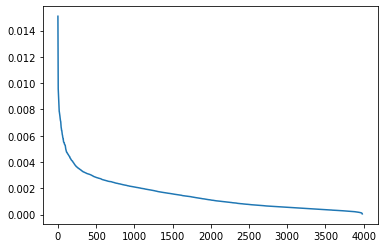

In [8]:
import heapq
features_var = list(cell_line_norm.var(axis=0))
re1 = list(map(features_var.index, heapq.nlargest(500, features_var))) #索引
re2 = heapq.nlargest(500, features_var) #元素
print(re1) 
print(cell_line_norm.var(axis=0)[re1])
import matplotlib.pyplot as plt
re1_sort = np.sort(cell_line_norm.var(axis=0))[::-1]
plt.plot(re1_sort)

In [9]:
# take the top 200 highly vairable features
features_top200 = cell_line_norm[:,list(map(features_var.index, heapq.nlargest(200, features_var)))]

Then we apply pca (elbow plot first).

[ 8.20898904e-12 -5.32907052e-15  2.64694933e-11 -8.14726064e-12
 -2.52913246e-11  2.43387532e-11 -3.44688722e-11  3.94884125e-11
  1.49071866e-11 -1.47046819e-11  1.58539848e-11 -1.43414169e-11
 -9.59410329e-12  1.74189552e-11  6.97575331e-12  2.56932253e-11
  3.62154751e-11 -1.51647583e-11  6.01740879e-12 -2.69548828e-11
  4.58566518e-12  2.88924440e-12  2.05790940e-11  1.84221527e-11
 -1.26543220e-12 -2.15294449e-12  4.43041159e-11  1.87161397e-11
 -1.70361503e-11  2.77600165e-11  7.14006632e-12  3.60071972e-11
  9.55502344e-12 -1.61604063e-11 -8.76809736e-12 -1.68789427e-11
  3.74278386e-12  1.24797950e-11  3.96198629e-11 -2.65742983e-12
 -1.90878424e-11  8.11706258e-12  1.63384861e-11  2.78506107e-11
  5.76738657e-12 -2.58726374e-11 -9.67581570e-12  2.74456013e-11
  1.01945119e-11 -1.66044956e-11  2.46789256e-11 -2.06572537e-11
  1.23598909e-11  2.11546336e-11 -2.81241697e-12  1.02922115e-11
 -1.14619425e-12  1.08046905e-12 -5.86570792e-11  1.03117515e-12
  3.59978714e-11 -8.76898

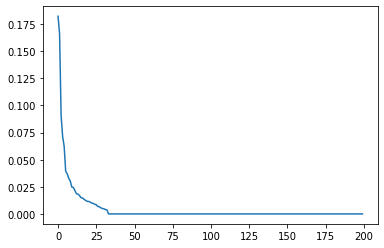

In [10]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
# scaling
scaler = preprocessing.StandardScaler()
features_norm = scaler.fit_transform(features_top200)
print(features_norm.sum(axis=0), features_norm.var(axis=0))
pca = PCA() #(n_components=30, copy=True, whiten=False)
features_pca = pca.fit(features_norm)   #fit_transform
print(pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_)

In [11]:
# take top 30 (12) directions 
pca = PCA(n_components=30) #(n_components=30, copy=True, whiten=False)
features_pca = pca.fit_transform(features_norm)

Embedding for the 15 overlapping drugs

In [12]:
drugs_embedding = pd.read_csv('dataset/drugfeatures_overlapped_ONeil38_Drug732.csv', header = None)
drugs_embedding[1] = drugs_name

In [13]:
# generate X for the selected (y)
#contains the data in both feature ordering ways (drug A - drug B - cell line and drug B - drug A - cell line)
#in the first half of the data the features are ordered (drug A - drug B - cell line)
#in the second half of the data the features are ordered (drug B - drug A - cell line)


X_emb = [] 
for i in range(len(selected)):
    drug_a = selected.iloc[i]['drug_a_name']
    drug_a_emb = list(np.array(drugs_embedding[drugs_embedding[1]==drug_a]).reshape(-1,)[2:])
    drug_b = selected.iloc[i]['drug_b_name']
    drug_b_emb = list(np.array(drugs_embedding[drugs_embedding[1]==drug_b]).reshape(-1,)[2:])
    cell_line_ind = selected.index[i]
    cell_line_emb = list(features_pca[cell_line_ind])


    X_emb.append(drug_a_emb+drug_b_emb+cell_line_emb)

for i in range(len(selected)):
    drug_a = selected.iloc[i]['drug_a_name']
    drug_a_emb = list(np.array(drugs_embedding[drugs_embedding[1]==drug_a]).reshape(-1,)[2:])
    drug_b = selected.iloc[i]['drug_b_name']
    drug_b_emb = list(np.array(drugs_embedding[drugs_embedding[1]==drug_b]).reshape(-1,)[2:])
    cell_line_ind = selected.index[i]
    cell_line_emb = list(features_pca[cell_line_ind])

    X_emb.append(drug_b_emb+drug_a_emb+cell_line_emb)

# scale X_emb to balance among drug_a drug_b and cell line
# scale each embedding to have mean 0 and variance 1
X_emb = np.array(X_emb)
scaler = preprocessing.StandardScaler()

X_emb[:,:10] = scaler.fit_transform(X_emb[:,:10])
X_emb[:,10:20] = scaler.fit_transform(X_emb[:,10:20])
X_emb[:,20:] = scaler.fit_transform(X_emb[:,20:])
#X_emb = scaler.fit_transform(X_emb)

In [14]:
with gzip.open('./dataset/X_15_emb_c30.p', "wb") as f:
    pickle.dump(X_emb, f)

## For original input

In [15]:
X_15drugs_39cel = np.vstack([X[selected.index], X[selected.index+int(X.shape[0]/2)]])

In [16]:
with gzip.open('./dataset/X_15.p', "wb") as f:
    pickle.dump(X_15drugs_39cel, f)